In [ ]:
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Download latest version
path = kagglehub.dataset_download("adilshamim8/student-depression-dataset")

print("Path to dataset files:", path)

data = pd.read_csv(path + "/student_depression_dataset.csv")

Path to dataset files: /home/nacho/.cache/kagglehub/datasets/adilshamim8/student-depression-dataset/versions/1


In [2]:
data.isna().sum()

id                                       0
Gender                                   0
Age                                      0
City                                     0
Profession                               0
Academic Pressure                        0
Work Pressure                            0
CGPA                                     0
Study Satisfaction                       0
Job Satisfaction                         0
Sleep Duration                           0
Dietary Habits                           0
Degree                                   0
Have you ever had suicidal thoughts ?    0
Work/Study Hours                         0
Financial Stress                         0
Family History of Mental Illness         0
Depression                               0
dtype: int64

Ninguna columna presenta valores nulos

In [3]:
data['Job Satisfaction'].value_counts()

Job Satisfaction
0.0    27893
2.0        3
4.0        2
1.0        2
3.0        1
Name: count, dtype: int64

La columna 'Job Satisfaction' no describe bien el dataset, ya que casi todos los valores son 0, por lo que no debería tomarse en cuenta

In [9]:
data['Age'].value_counts().sort_index()

Age
18.0    1587
19.0    1560
20.0    2237
21.0    1726
22.0    1160
23.0    1645
24.0    2258
25.0    1784
26.0    1155
27.0    1462
28.0    2133
29.0    1950
30.0    1145
31.0    1427
32.0    1262
33.0    1893
34.0    1468
35.0      10
36.0       7
37.0       2
38.0       8
39.0       3
41.0       1
42.0       4
43.0       2
44.0       1
46.0       2
48.0       3
49.0       1
51.0       1
54.0       1
56.0       1
58.0       1
59.0       1
Name: count, dtype: int64

Text(0.5, 1.0, 'Ages $<= 34$ vs Ages $> 34$')

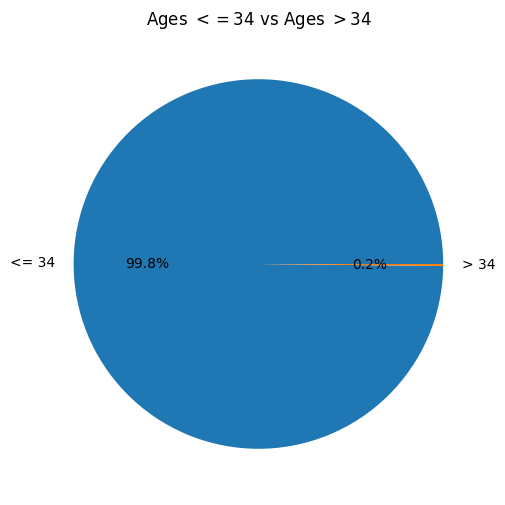

In [26]:
# pie chart representing ages <= 34 versus ages > 34
edades = [data['Age'].value_counts().sort_index().loc[18:34].sum(), data['Age'].value_counts().sort_index().loc[35:].sum()]
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(edades, labels=['<= 34', '> 34'], autopct='%1.1f%%')
ax.set_title('Ages $<= 34$ vs Ages $> 34$')

Hasta los 34 años hay una cantidad similar de registros. Mas allá de eso el dataset contiene menos de 10 datos por grupo etario, por lo que si se quiere estudiar la data por edad, hay que hacer algo respecto al grupo >34

<Axes: title={'center': 'Porcentaje de depresión por edad'}, xlabel='Age'>

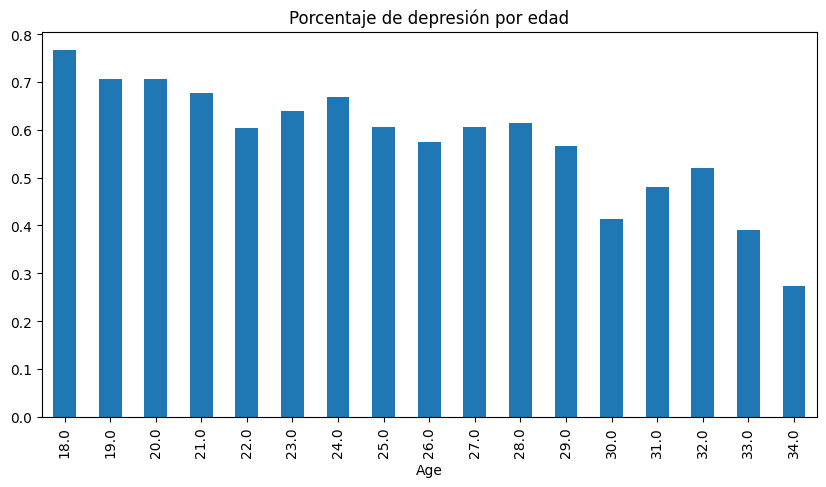

In [10]:
data[data['Age']<=34].groupby('Age')['Depression'].mean().plot(kind='bar', figsize=(10, 5), title='Porcentaje de depresión por edad')

<Axes: title={'center': 'Porcentaje de depresión separado por presencia de ideación suicida'}, xlabel='ideacion'>

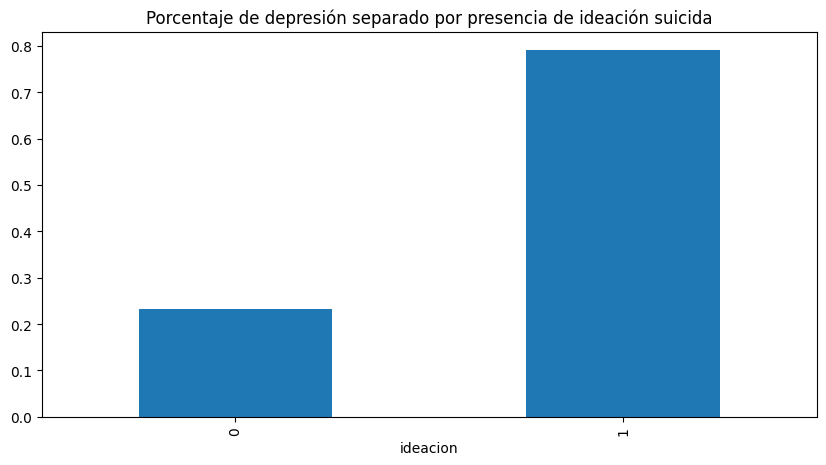

In [11]:
data['ideacion'] = data['Have you ever had suicidal thoughts ?'].map({'Yes': 1, 'No': 0})
data.groupby('ideacion')['Depression'].mean().plot(kind='bar', figsize=(10, 5), title='Porcentaje de depresión separado por presencia de ideación suicida')

<Axes: title={'center': 'Porcentaje de ideación suicida separado por presencia de depresión'}, xlabel='Depression'>

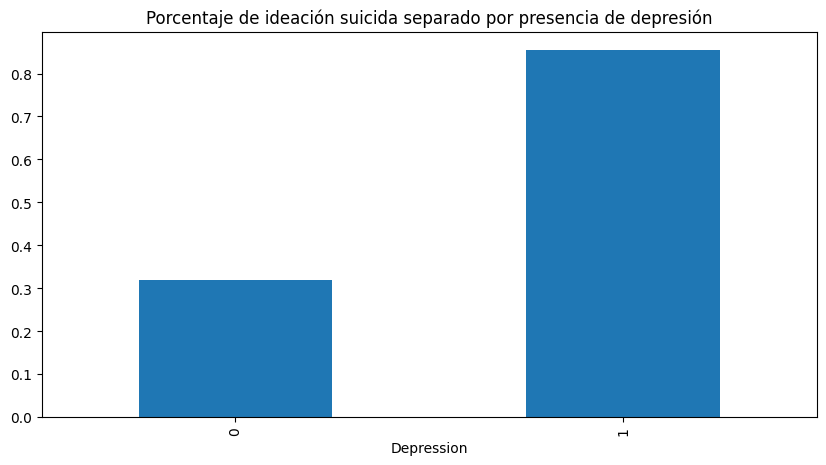

In [13]:
data.groupby('Depression')['ideacion'].mean().plot(kind='bar', figsize=(10, 5), title='Porcentaje de ideación suicida separado por presencia de depresión')